In [11]:
import os
import gc
import time
import math
import torch
import hashlib
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from utils import (
    show_images_in_grid,
    get_weight_vector,
    load_state,
    save_state,
    train_model
)

from dataset import ExoNetDatasetV2 as ExoNetDataset

from PIL import Image
from tqdm import tqdm
from itertools import product
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2 as transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [12]:
# Define seed for random
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Read Datasets

In [13]:
# Set directories and file paths
DATASET_DIR = "/mnt/f/ExoNet_Images/ExoNet_Images"
DATAFRAMES_DIR = "/mnt/f/Datasets/Tesis/"

In [5]:
seq_train_df = pd.read_pickle(os.path.join(DATAFRAMES_DIR, "seq_train_df.pkl"))
seq_val_df = pd.read_pickle(os.path.join(DATAFRAMES_DIR, "seq_val_df.pkl"))
test_df = pd.read_pickle(os.path.join(DATAFRAMES_DIR, "test_df.pkl"))

In [6]:
seq_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639121 entries, 0 to 639120
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   video     639121 non-null  object
 1   frame     639121 non-null  int64 
 2   class     639121 non-null  object
 3   path      639121 non-null  object
 4   sequence  639121 non-null  object
dtypes: int64(1), object(4)
memory usage: 24.4+ MB


In [14]:
# Transforms
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
MEAN_DATASET = [0.485, 0.456, 0.406]
STD_DATASET = [0.229, 0.224, 0.225]

unique_labels = seq_train_df['class'].unique()
encoder = LabelEncoder()
encoder.fit(unique_labels)

train_image_transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(
        mean=MEAN_DATASET,
        std=STD_DATASET
    ),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
])

val_image_transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(
        mean=MEAN_DATASET,
        std=STD_DATASET
    )
])

test_image_transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(
        mean=MEAN_DATASET,
        std=STD_DATASET
    )
])

In [15]:
# Datasets objects
# Sequence length is 15. This value was used to generate sequence of images.
# If the secuence value is modified, the dataset pre-processing must be modified also.
SEQUENCE_LENGTH = 15
training_dataset = ExoNetDataset(
    df_labels=seq_train_df,
    seq_len=SEQUENCE_LENGTH,
    target_transform=encoder.transform,
    transform=train_image_transform
)
validation_dataset = ExoNetDataset(
    df_labels=seq_val_df,
    seq_len=SEQUENCE_LENGTH,
    target_transform=encoder.transform,
    transform=val_image_transform
)
print(f"[Training] Total video chunks of {SEQUENCE_LENGTH} frames: {len(training_dataset)}")
print(f"[Validation] Total video chunks of {SEQUENCE_LENGTH} frames: {len(validation_dataset)}")

frames_tensor, labels_tensor = training_dataset[0]
print(f"Frames shape: {frames_tensor.shape}. Labels shape: {labels_tensor.shape}")


[Training] Total video chunks of 15 frames: 639121
[Validation] Total video chunks of 15 frames: 174686
Frames shape: torch.Size([15, 3, 224, 224]). Labels shape: torch.Size([1])


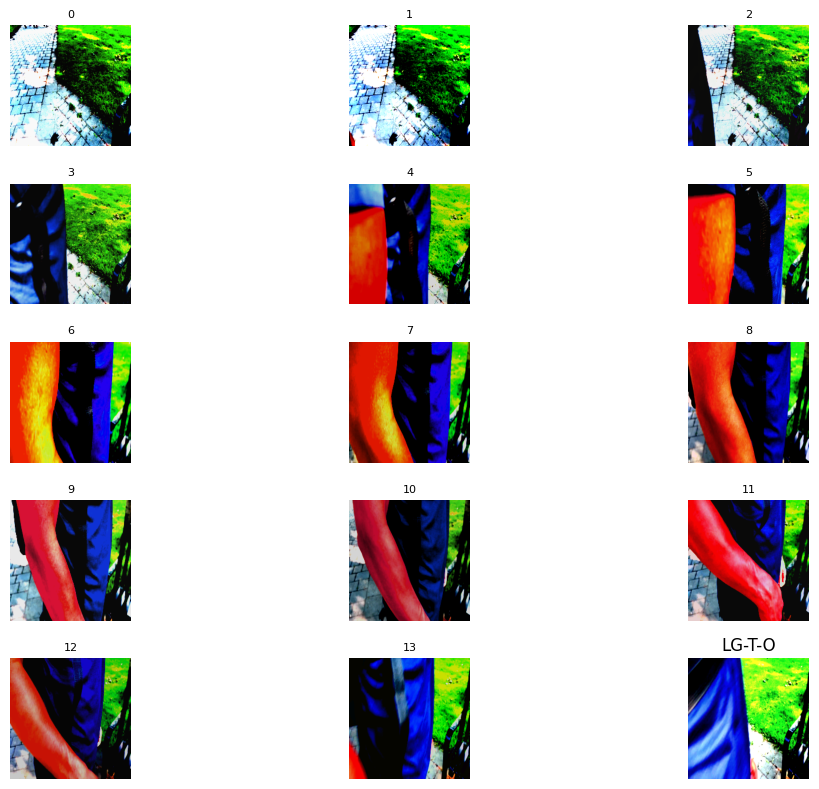

In [16]:
show_images_in_grid(
    tensor_images=frames_tensor,
    labels_images=encoder.inverse_transform(labels_tensor),
    cols=3
)

## ConvLSTM n channels

In [17]:
class ConvLSTMCell(nn.Module):
    def __init__(
        self,
        input_channels,
        hidden_channels,
        kernel_size,
        bias=True,
        input_dropout=0.0,
        recurrent_dropout=0.0
    ):
        super().__init__()
        padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.hidden_channels = hidden_channels

        self.conv = nn.Conv2d(
            input_channels + hidden_channels,
            4 * hidden_channels,
            kernel_size,
            padding=padding,
            bias=bias,
        )
        self.input_dropout = nn.Dropout2d(input_dropout)
        self.recurrent_dropout = nn.Dropout2d(recurrent_dropout)

    def forward(self, x, h, c):
        if self.input_dropout.p > 0.0:
            x = self.input_dropout(x)
        if self.recurrent_dropout.p > 0.0:
            h = self.recurrent_dropout(h)
        
        combined = torch.cat([x, h], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_out, 4, dim=1)

        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

In [18]:
class ConvLSTM(nn.Module):
    def __init__(
        self,
        input_channels,
        hidden_channels_list,
        kernel_size,
        num_classes,
        device,
        input_dropout=0.0,
        recurrent_dropout=0.0,
        output_dropout=0.0,
    ):
        super().__init__()
        self.num_layers = len(hidden_channels_list)

        layers = []
        for i in range(self.num_layers):
            in_channels = input_channels if i == 0 else hidden_channels_list[i - 1]
            layers.append(
                ConvLSTMCell(
                    in_channels,
                    hidden_channels_list[i],
                    kernel_size[i],
                    input_dropout=input_dropout,
                    recurrent_dropout=recurrent_dropout
                ).to(device)
            )
        self.layers = nn.ModuleList(layers)
        self.avg_pool_2d = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Linear(hidden_channels_list[-1], num_classes)
        self.output_dropout = nn.Dropout2d(output_dropout)

    def forward(self, x, h=None, c=None):
        # x: (B, T, C, H, W) -> feature maps from EfficientNet
        B, T, _, H, W = x.size()

        if h is None:
            h = [torch.zeros(B, ch, H, W, device=x.device) for ch in self._hidden_channels]
            c = [torch.zeros(B, ch, H, W, device=x.device) for ch in self._hidden_channels]

        outputs = []
        for t in range(T): # For each timestep in the sequence
            input_t = x[:, t]

            for layer_idx, cell in enumerate(self.layers):
                h[layer_idx], c[layer_idx] = cell(input_t, h[layer_idx], c[layer_idx])
                input_t = h[layer_idx]
            
        dropped = self.output_dropout(h[-1])
        pooled = self.avg_pool_2d(dropped)  # (B, C_hidden, 1, 1)
        pooled = pooled.view(B, -1)  # (B, C_hidden)

        frame_output = self.classifier(pooled)  # (B, num_classes)
        outputs.append(frame_output)

        outputs = torch.stack(outputs, dim=1)  # (B, T, num_classes)
        return outputs, h, c

    @property
    def _hidden_channels(self):
        return [cell.hidden_channels for cell in self.layers]


In [19]:
class CnnExtractorConvLSTM(nn.Module):
    def __init__(
        self,
        hidden_channels_list,
        kernel_size,
        num_classes,
        device,
        feature_extractor,
        feature_dim,
        name,
        input_dropout,
        recurrent_dropout,
        output_dropout
    ):
        super().__init__()
        self.name = name
        self.feature_extractor = feature_extractor
        self.feature_extractor = self.feature_extractor.to(device=device)

        # ConvLSTM on top of feature maps
        self.convlstm = ConvLSTM(
            input_channels=feature_dim,
            hidden_channels_list=hidden_channels_list,
            kernel_size=kernel_size,
            num_classes=num_classes,
            input_dropout=input_dropout,
            recurrent_dropout=recurrent_dropout,
            output_dropout=output_dropout,
            device=device
        ).to(device)

    def forward(self, x, h=None, c=None):
        # x: (B, T, 3, H, W) raw RGB frames
        B, T, C, H, W = x.size()

        features = []
        for t in range(T):
            with torch.no_grad():
                f_t = self.feature_extractor(x[:, t])  # (B, 1280, H', W')
                features.append(f_t)

        features = torch.stack(features, dim=1)  # (B, T, C_feat, H', W')
        
        out, h_prev, c_prev = self.convlstm(features, h, c)  # (B, T, num_classes)
        return out, h_prev, c_prev


In [20]:
def test(m_test, batch_size, seq_length, channels=3, heigth=224, weigth=224):
    m_test.eval()
    x = torch.randn(batch_size, seq_length, 3, heigth, weigth).to("cuda")
    out, h, c = m_test(x)
    out, h, c = m_test(x, h, c)
    print(out.shape, len(h), len(c))

## EfficientNetB0 with convLSTM

In [21]:
efficientnet_convLSTM = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_convLSTM_dim = 1280
efficientnet_name = "EfficientNetB0_convLSTM"

In [22]:
# test
m_test = CnnExtractorConvLSTM(
    num_classes=len(unique_labels),
    hidden_channels_list=[128, 64],
    kernel_size=[(3,3),(3,3)],
    device="cuda",
    feature_extractor=efficientnet_convLSTM.features,
    feature_dim=efficientnet_convLSTM_dim,
    name=efficientnet_name,
    input_dropout=0.2,
    recurrent_dropout=0.1,
    output_dropout=0.3
).to(device="cuda")
test(m_test, 64, SEQUENCE_LENGTH)
test(m_test, 1, 1)

torch.Size([64, 1, 12]) 2 2
torch.Size([1, 1, 12]) 2 2


## MobileNetV2 with convLSTM

In [23]:
mobnet_convLSTM = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
mobnet_convLSTM_dim = 1280
mobnet_name = "MobileNetV2_convLSTM"

In [24]:
# test
m_test = CnnExtractorConvLSTM(
    num_classes=len(unique_labels),
    hidden_channels_list=[128, 64],
    kernel_size=[(3,3),(3,3)],
    device="cuda",
    feature_extractor=mobnet_convLSTM.features,
    feature_dim=mobnet_convLSTM_dim,
    name=mobnet_name,
    input_dropout=0.2,
    recurrent_dropout=0.1,
    output_dropout=0.3
).to(device="cuda")
test(m_test, 64, SEQUENCE_LENGTH)
test(m_test, 1, 1)

torch.Size([64, 1, 12]) 2 2
torch.Size([1, 1, 12]) 2 2


## VGG16 with convLSTM

In [25]:
vgg16_convLSTM = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg16_convLSTM_dim = 512
vgg16_name = "VGG16_convLSTM"

In [26]:
# test
m_test = CnnExtractorConvLSTM(
    num_classes=len(unique_labels),
    hidden_channels_list=[128, 64],
    kernel_size=[(3,3),(3,3)],
    device="cuda",
    feature_extractor=vgg16_convLSTM.features,
    feature_dim=vgg16_convLSTM_dim,
    name=vgg16_name,
    input_dropout=0.2,
    recurrent_dropout=0.1,
    output_dropout=0.3
).to(device="cuda")
test(m_test, 64, SEQUENCE_LENGTH)
test(m_test, 1, 1)

torch.Size([64, 1, 12]) 2 2
torch.Size([1, 1, 12]) 2 2


# Training

In [27]:
# Checking if encoder.classes_ and classes obtained after applying count method to df are in the same order
count_class_train = seq_train_df.groupby(['class'])['frame'].count()
classes_from_df = list(count_class_train.to_dict().keys())
print("Are classes equal? Answer:", str(classes_from_df).replace(',','') == str(encoder.classes_).replace('\n',''))
print(count_class_train.to_dict())
train_loss_weights = get_weight_vector(count_class_train.to_dict())

Are classes equal? Answer: True
{'DS-T-LG': 20240, 'DW-S': 24272, 'DW-T-O': 12733, 'IS-S': 12754, 'IS-T-DW': 21516, 'IS-T-LG': 7696, 'LG-S': 65353, 'LG-T-DS': 16212, 'LG-T-DW': 252116, 'LG-T-IS': 18782, 'LG-T-O': 101762, 'LG-T-SE': 85685}


/mnt/f/thesis/neural-networks/utils.py:49: UserWarning: Be sure encoder.classes_ and class_value.keys() are the same
  warnings.warn(f"Be sure encoder.classes_ and class_value.keys() are the same")


In [28]:
# define params grid
batch_sizes = [128]
device = "cuda"
lr = 1e-3
params = {
    "batches": batch_sizes,
    "epochs": [ 30 ],
    "dropout": [
        [0.2, 0.1, 0.2]
    ], # input, recurrent, output
    "layers": [[128, 64, 32]],
}
model_names = ['MobileNetV2_convLSTM', 'EfficientNet_convLSTM', 'VGG16_convLSTM']

In [29]:
model_params = list(product(model_names, *params.values()))
best_results = {
    'EfficientNet_convLSTM': {
        'val_loss': float('inf'),
        'params': None
    },
    'MobileNetV2_convLSTM': {
        'val_loss': float('inf'),
        'params': None
    },
    'VGG16_convLSTM': {
        'val_loss': float('inf'),
        'params': None
    }
}
checkpoints_prefixes = dict()

for i, (model_name, *combo_params) in enumerate(model_params, start=1):
    if model_name == 'EfficientNet_convLSTM':
        model = CnnExtractorConvLSTM(
            num_classes=len(unique_labels),
            hidden_channels_list=combo_params[3],
            kernel_size=[(3,3) for _ in combo_params[3]],
            device="cuda",
            feature_extractor=efficientnet_convLSTM.features,
            feature_dim=efficientnet_convLSTM_dim,
            name=model_name,
            input_dropout=combo_params[2][0],
            recurrent_dropout=combo_params[2][1],
            output_dropout=combo_params[2][2]
        ).to(device="cuda")
    if model_name == 'MobileNetV2_convLSTM':
        model = CnnExtractorConvLSTM(
            num_classes=len(unique_labels),
            hidden_channels_list=combo_params[3],
            kernel_size=[(3,3) for _ in combo_params[3]],
            device="cuda",
            feature_extractor= mobnet_convLSTM.features,
            feature_dim=mobnet_convLSTM_dim,
            name=model_name,
            input_dropout=combo_params[2][0],
            recurrent_dropout=combo_params[2][1],
            output_dropout=combo_params[2][2]
        ).to(device="cuda")
    if model_name == 'VGG16_convLSTM':
        model = CnnExtractorConvLSTM(
            num_classes=len(unique_labels),
            hidden_channels_list=combo_params[3],
            kernel_size=[(3,3) for _ in combo_params[3]],
            device="cuda",
            feature_extractor= vgg16_convLSTM.features,
            feature_dim=vgg16_convLSTM_dim,
            name=model_name,
            input_dropout=combo_params[2][0],
            recurrent_dropout=combo_params[2][1],
            output_dropout=combo_params[2][2]
        ).to(device="cuda")

    criterion = nn.CrossEntropyLoss(weight=train_loss_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    checkpoint_prefix = hash(str(combo_params))
    checkpoints_prefixes[f'{checkpoint_prefix}'] = combo_params
    torch.save(checkpoints_prefixes, f"/mnt/f/Checkpoints/Tesis/checkpoint_prefixes.pth")
    checkpoint_path = f"/mnt/f/Checkpoints/Tesis/{model_name}_{checkpoint_prefix}.pth"
    checkpoint_path_best = f"/mnt/f/Checkpoints/Tesis/{model_name}_{checkpoint_prefix}_best.pth"
    
    train_dataset = ExoNetDataset(
        df_labels=seq_train_df,
        seq_len=SEQUENCE_LENGTH,
        target_transform=encoder.transform,
        transform=train_image_transform
    )
    val_dataset = ExoNetDataset(
        df_labels=seq_val_df,
        seq_len=SEQUENCE_LENGTH,
        target_transform=encoder.transform,
        transform=val_image_transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=combo_params[0],
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=combo_params[0],
        shuffle=False,
        num_workers=6,
        pin_memory=True
    )

    model, history, val_loss = train_model(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        checkpoint_path=checkpoint_path,
        checkpoint_path_best=checkpoint_path_best,
        epochs=combo_params[1],
        device="cuda",
        n_processes=len(model_params),
        i_process=i
    )
    if val_loss < best_results[model_name]['val_loss']:
        best_results[model_name]['val_loss'] = val_loss
        best_results[model_name]['params'] = combo_params
        
    torch.save(best_results, f"/mnt/f/Checkpoints/Tesis/best_results.pth")

Epoch [1/30] - Proc: 1/3:   0%|                              | 7/4994 [00:45<9:02:19,  6.52s/it, acc=0.0357, loss=0.446]


KeyboardInterrupt: 